In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from src.clip_conv import ClipConv
import yaml
import cv2
import torch
import torchvision.transforms as T
from torchvision.transforms import Normalize
from thirdparty.FOUND.misc import load_config
import torch.nn as nn
from thirdparty.FOUND.model import FoundModel
import torch.nn.functional as F
from collections import namedtuple

import transformers

transformers.logging.set_verbosity_info()


#### Helper functions

In [79]:
@torch.no_grad()
def get_mask(img, text_prompts, saliency_model):
    W, H = img.size
    img = transform(img).to(device).unsqueeze(0)
    if text_prompts[0] != 'background': text_prompts.insert(0, 'background')
    cc_model = ClipConv(args(**config), text_prompts).to(device)
    clip_map = cc_model(img)
    preds, _, shape_f, att = saliency_model.forward_step(normalize(img), for_eval=True)
    sigmoid = nn.Sigmoid()
    h, w = img.shape[-2:]
    preds_up = F.interpolate(
    preds, scale_factor=saliency_model.vit_patch_size, mode="bilinear", align_corners=False
    )[..., :h, :w]
    sal = (sigmoid(preds_up.detach())).float()
    num_classes = clip_map.shape[1]
    logits_mask = torch.cat([
                        1 - sal,  # B 1 H W,
                        sal.repeat(1, num_classes - 1, 1, 1)  # B N-1, H, W
                    ],
                    dim=1,
                )  # B N H W
    out_ = (clip_map * logits_mask).argmax(dim=1).float()
    out_ = F.interpolate(out_[None], (H, W), mode="nearest")[0,0,:,:].cpu()
    
    return out_
    
def mask_to_png(mask, colormap, img):
    rgb_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    mask[mask == 255] = 0

    for l in np.unique(mask):
        rgb_mask[mask == l] = colormap[int(l)]

    overlay = cv2.addWeighted(img, 0.8, rgb_mask, 0.7,0)
    return rgb_mask, overlay    

def save_fig(img, filename):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.margins(0,0)
    plt.savefig(f'{filename}.png', bbox_inches='tight', pad_inches = 0)
    plt.close()
    

### Model configuration part

In [5]:
device = 'cuda' # put your device

cfg = 'configs/cfg_clip_coco.yaml'
config = yaml.safe_load(open(cfg))
args = namedtuple('cfg', config.keys())
found_cfg = "thirdparty/FOUND/configs/found_DUTS-TR.yaml"
found_weights = "thirdparty/FOUND/data/weights/decoder_weights.pt"

transforms_list = [
                T.ToTensor(),
            T.Resize((256, 256), interpolation=0)]
transform = T.Compose(transforms_list)

/home/mwysocz1/anaconda3/envs/multi-od/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


#### Load FOUND model

In [6]:
found_config = load_config(found_cfg)
    # ------------------------------------
    # Load the model
found_model = FoundModel(vit_model=found_config.model["pre_training"],
                        vit_arch=found_config.model["arch"],
                        vit_patch_size=found_config.model["patch_size"],
                        enc_type_feats=found_config.found["feats"],
                        bkg_type_feats=found_config.found["feats"],
                        bkg_th=found_config.found["bkg_th"]).eval().to(device)
found_model.decoder_load_weights(found_weights)

normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

hyperparameters: model={'arch': 'vit_small', 'patch_size': 8, 'pre_training': 'dino'}, found={'bkg_th': 0.3, 'feats': 'k'}, training={'dataset': 'DUTS-TR', 'dataset_set': None, 'seed': 0, 'max_iter': 500, 'nb_epochs': 3, 'batch_size': 50, 'lr0': 0.05, 'step_lr_size': 50, 'step_lr_gamma': 0.95, 'w_bs_loss': 1.5, 'w_self_loss': 4.0, 'stop_bkg_loss': 100, 'crop_size': 224, 'scale_range': [0.1, 3.0], 'photometric_aug': 'gaussian_blur', 'proba_photometric_aug': 0.5, 'cropping_strategy': 'random_scale'}, evaluation={'type': 'saliency', 'datasets': ['DUT-OMRON', 'ECSSD'], 'freq': 50}
Loading model from weights thirdparty/FOUND/data/weights/decoder_weights.pt.


### Load an image

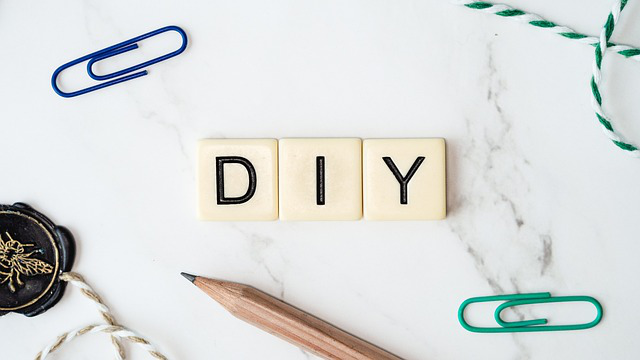

In [19]:
img = Image.open('images/diy-5090797_640.jpg').convert('RGB') # path to your image
img

### Enter prompts

Note 1: no need to put 'a photo of ..' as it is encoded in the model.

In [69]:
text_prompts =["background", "scrabble", "pencil", "rubber stamp", "paper clip"]

### Get segmentation mask

In [70]:
mask = get_mask(img, text_prompts, found_model)
mask.shape

loading configuration file config.json from cache at /home/mwysocz1/.cache/huggingface/hub/models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K/snapshots/24a1247a8a52ca09638b6420cd58550db755b324/config.json
Model config CLIPVisionConfig {
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "gelu",
  "hidden_size": 768,
  "image_size": 224,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 32,
  "projection_dim": 512,
  "transformers_version": "4.29.2"
}

loading weights file pytorch_model.bin from cache at /home/mwysocz1/.cache/huggingface/hub/models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K/snapshots/24a1247a8a52ca09638b6420cd58550db755b324/pytorch_model.bin
Some weights of the model checkpoint at laion/CLIP-ViT-B-32-laion2B-s34B-b79K were not used when initializing CLIPVisionModelWithProject

torch.Size([360, 640])

In [74]:
m, over = mask_to_png(mask.numpy(), [[0, 0, 0], [10, 206, 250], [255, 140, 31], [55, 240, 31], [200, 0, 25]], np.array(img))

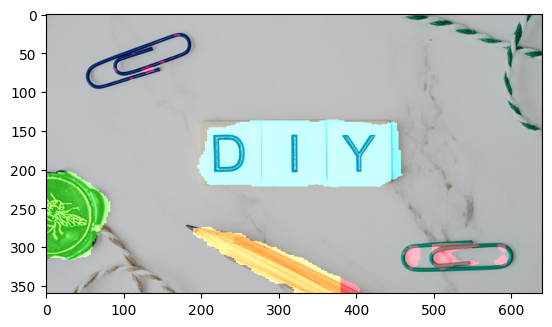

In [75]:
plt.imshow(over)

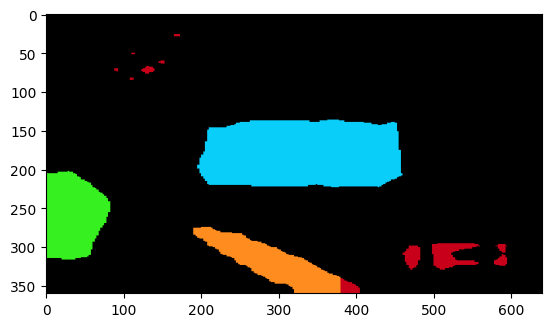

In [76]:
plt.imshow(m)

In [80]:
save_fig(m, 'diy2_ours')